# Overlay LC to create mask applied before for zonal stats of AGB
* to run zonal stats for certain land cover zones in WorldCover s3 dataset

In [68]:
import geopandas as gpd
import pandas as pd
import rasterio
import os
import rioxarray
import fiona

import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma

In [10]:
# a writable outdir
outdir = '/projects/my-public-bucket/analyze_agb'

In [11]:
COVAR_FOOTPRINTS_FN = '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg'

TILE_NUM = 131 #3417# 4253
INDEX_FN = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
INDEX_LYR = 'boreal_tiles_v003'

In [12]:
boreal_tiles = gpd.read_file(INDEX_FN)
tile_group_region_string = "america"
tiles_subset = boreal_tiles[boreal_tiles['tile_group'].str.contains(tile_group_region_string)]
tiles_subset.head()

,tile_num,tile_version,tile_group,map_version,geometry
328,329,version 1,north america east,None,"POLYGON ((4688522.000 7713304.000, 4778522.000..."
329,330,version 1,north america east,None,"POLYGON ((4778522.000 7713304.000, 4868522.000..."
330,331,version 1,north america east,None,"POLYGON ((4868522.000 7713304.000, 4958522.000..."
331,332,version 1,north america east,None,"POLYGON ((4958522.000 7713304.000, 5048522.000..."
357,358,version 1,north america east,None,"POLYGON ((4508522.000 7623304.000, 4598522.000..."


https://gis.stackexchange.com/questions/345917/overlay-two-raster-geotiffs-using-rasterio-mask

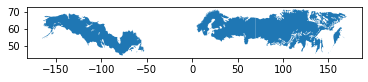

In [13]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
canada = world[world.name == 'Canada']
canada_alaska = pd.concat([alaska, canada])
#canada_alaska.plot()
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
boreal_gdf.plot()

### Get the Worldcover covariate tiles

In [14]:
# Build a VRT of the LC on s3?
covar_footprint_tiles = gpd.read_file(COVAR_FOOTPRINTS_FN)
covar_footprint_tiles.head()

,footprint_name,path,file,s3_path,geometry
0,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E006_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((9.00000 0.00000, 9.00000 3.00000, 6...."
1,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E009_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((12.00000 0.00000, 12.00000 3.00000, ..."
2,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E012_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((15.00000 0.00000, 15.00000 3.00000, ..."
3,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E015_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((18.00000 0.00000, 18.00000 3.00000, ..."
4,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E018_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((21.00000 0.00000, 21.00000 3.00000, ..."


### Subset covariate tiles by region
* Build the spatial selector with 'intersects'
* do the subset accord to region (where region is identified with the spatial selector)

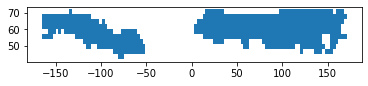

In [15]:
tile_group_region_string = 'wwf_boreal'

boreal_gdf['dissolve_field'] = 'for intersect'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles.intersects(boreal_gdf.dissolve(by='dissolve_field').iloc[0].geometry)
covar_footprint_tiles_subset = covar_footprint_tiles[selector]
covar_footprint_tiles_subset.plot()

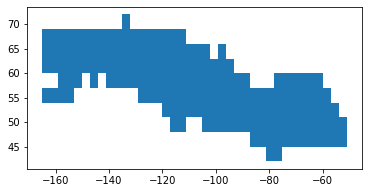

In [16]:
tile_group_region_string = tile_group_region_string + '_america'

region_selection_geometry = boreal_gdf.cx[-165:-50, 40:90].iloc[0].geometry

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles_subset.intersects(region_selection_geometry)

covar_footprint_tiles_subset = covar_footprint_tiles_subset[selector]
covar_footprint_tiles_subset.plot()

In [9]:
# cog bands dict
bands_dict = {'1': 'esa_worldcover_v100_2020'
             }
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

### Set up the clip INDEX: the GPKG that holds 1 specific clip polygon

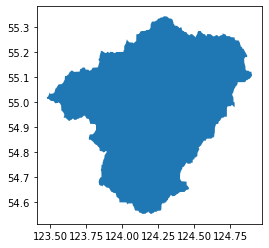

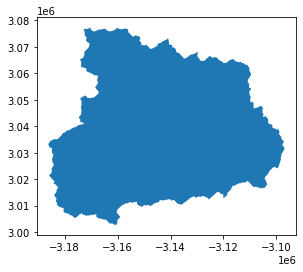

In [225]:
#TILE_NUM = 12967
#INDEX_FN = '/projects/shared-buckets/lduncanson/dem30m_tiles_v2.geojson'#
#INDEX_LYR = 'dem30m_tiles_v2'

ID_COL_NAME = 'tile_num'
TILE_NUM = 131 #3417# 4253
INDEX_FN = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
INDEX_LYR = 'boreal_tiles_v003'

if True:
    
    # Manually select hybas file and HYBAS_ID of interest
    HYBAS_FILE = 'hybas_lake_as_lev07_v1c'
    ID_COL_NAME = 'HYBAS_ID'
    #TILE_NUM = 4070084980 #4070000010 #3417# 4253
    
    INDEX_FN = f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp'
    ADD_STR = '-reprj'
    INDEX_REPRJ_FN = INDEX_FN.replace('.shp', ADD_STR+'.gpkg')
    
    # Reproject hydrobasin to equal area (boreal_tiles)
    gpd.read_file(INDEX_FN).to_crs(boreal_tiles.crs).to_file(INDEX_REPRJ_FN, driver='GPKG')
    
    INDEX_LYR = HYBAS_FILE + ADD_STR
    
    # Read and plot the basin in orig prj
    z = gpd.read_file(INDEX_FN)
    
    # Get random HYBAS
    TILE_NUM = z.sample(n=1)[ID_COL_NAME].to_list()[0]
    
    z[z[ID_COL_NAME]==TILE_NUM].plot()
    
    # Read and plot the basin in reproj
    z = gpd.read_file(INDEX_REPRJ_FN)
    
    z[z[ID_COL_NAME]==TILE_NUM].plot()
    
    # Now change this variable back to what BUILD_STACK_DICT wants
    INDEX_FN = INDEX_REPRJ_FN

In [223]:
z.sample(n=1)[ID_COL_NAME].to_list()[0]

4070726630

## Using hydrobasin as CLIP INDEX, run build_stack.py (now featuring a geom clip!) for ESA Worldcover and AGB
* reprojected to equal area using boreal_tile_index
* so output has same res, crs, and clip extent

In [226]:
#BUILD_STACK_DICT = {'INDEX_FN':INDEX_FN,'ID_COL_NAME':ID_COL_NAME,'TILE_NUM':TILE_NUM,'INDEX_LYR':INDEX_LYR,'RASTER_NAME':'','COVAR_TILE_FN':'', 'IN_COVAR_S3_COL':'', 'NODATA_VAL':''}
BUILD_STACK_DICT_LIST = [
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # Worldcover data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
            'RASTER_NAME': 'esa_worldcover_v100_2020',
            'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 0,
            'OUTPUT_CLIP_COG_FN':''
        },
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctlyy in 4326 - 
            'RASTER_NAME': 'biomass_prelim',
            'COVAR_TILE_FN': '/projects/shared-buckets/lduncanson/DPS_tile_lists/AGB_tindex_master.json',
            'IN_COVAR_S3_COL': 's3',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':''
        }
]

In [65]:
BUILD_STACK_DICT_LIST[1]

{'INDEX_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_as_lev07_v1c-reprj.gpkg',
 'ID_COL_NAME': 'HYBAS_ID',
 'TILE_NUM': 4070084980,
 'INDEX_LYR': 'hybas_lake_as_lev07_v1c-reprj',
 'RASTER_NAME': 'biomass_prelim',
 'COVAR_TILE_FN': '/projects/shared-buckets/lduncanson/DPS_tile_lists/AGB_tindex_master.json',
 'IN_COVAR_S3_COL': 's3',
 'NODATA_VAL': -9999,
 'OUTPUT_CLIP_COG_FN': ''}

In [227]:
for BUILD_STACK_DICT in BUILD_STACK_DICT_LIST:
    if False:
        # --Special temporary case
        # Uh oh, any mosiac json needs to have the correct projection set
        # TODO: fix the setting of the MosaicJson in 3_DPS_review_pmm_v3
        if BUILD_STACK_DICT['RASTER_NAME'] == 'biomass_prelim':

            x = gpd.read_file(COVAR_TILE_FN)
            print('Reset projection and reproject...')
            x = x.set_crs(boreal_tiles.crs, allow_override=True, inplace=True).to_crs(4326)

            # Write a new JSON that should have the prj set correctly in 4326
            COVAR_TILE_FN = os.path.join('/projects/my-public-bucket/analyze_agb' , os.path.split(COVAR_TILE_FN)[1])
            print(COVAR_TILE_FN)
            x.to_file(COVAR_TILE_FN, driver='GeoJSON', overwrite=True)

            ## Verify 4326
            #ax = x.plot()
            #z[z[ID_COL_NAME]==TILE_NUM].to_crs(4326).plot(color='red', ax=ax)

    # INDEX clip shapes should be in equal area
    # COVAR_TILE_FN tiles (of raster COGs) should be in 4326
    args = f"--in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    --in_tile_num {BUILD_STACK_DICT['TILE_NUM']} \
    --tile_buffer_m 0 \
    --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    -o /projects/test_data/ \
    --topo_off \
    --covar_src_name {BUILD_STACK_DICT['RASTER_NAME']} \
    --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    --clip" #<-- testing a clip to polygon
    
    BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN'] = f"/projects/test_data/{BUILD_STACK_DICT['RASTER_NAME']}_{BUILD_STACK_DICT['TILE_NUM']}_cog.tif"
    
    print(args)
    !python /projects/Developer/icesat2_boreal/lib/build_stack.py $args

--in_tile_fn /projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_as_lev07_v1c-reprj.gpkg     --in_tile_id_col HYBAS_ID     --in_tile_num 4070083020     --tile_buffer_m 0     --in_tile_layer hybas_lake_as_lev07_v1c-reprj     -o /projects/test_data/     --topo_off     --covar_src_name esa_worldcover_v100_2020     --covar_tile_fn /projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg     --in_covar_s3_col s3_path     --input_nodata_value 0     --clip
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
The covariate's filename(s) intersecting the 0 m bbox for tile id 4070083020:
 s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N54E123_Map.tif
bbox: [-3186121.23807665, 3002721.0025259983, -3096914.5

In [228]:
# For each clip INDEX (polygon) there are 2 corresponding output clipped COGs you need
BASIN_COG_DICT = {'landcover_cog_fn': '', 'biomass_cog_fn':''}
for BUILD_STACK_DICT in BUILD_STACK_DICT_LIST:
    if 'worldcover' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'landcover_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    else:
        BASIN_COG_DICT.update({'biomass_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
BASIN_COG_DICT

{'landcover_cog_fn': '/projects/test_data/esa_worldcover_v100_2020_4070083020_cog.tif',
 'biomass_cog_fn': '/projects/test_data/biomass_prelim_4070083020_cog.tif'}

In [83]:
cog_fn = '/projects/tmp/esa_worldcover_v100_2020_131_cog.tif'
#cog_fn = f'/projects/tmp/{RASTER_NAME}_{TILE_NUM}_cog.tif'
cog_fn = '/projects/test_data/esa_worldcover_v100_2020_4070084980_cog.tif'
covar_stack_names = ['esa worldcover']

In [148]:
vrt_fn = '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'
with rasterio.open(vrt_fn) as d:
    print(d.nodatavals)

(-3.399999952144364e+38,)


In [237]:
# https://www.neonscience.org/resources/learning-hub/tutorials/mask-raster-py
# Define the plot_band_array function from Day 1


### Open clipped Worldcover COG and corresponding AGB, loop over LC classes, masking, summing, etc

1
lc_arr shape: (2488, 2973)
agb nodata value: None
agb_arr shape: (2488, 2973)
0 nodata 0
	# lc pixels in mask:				0
1 Trees 10
	# lc pixels in mask:				4228465
	Min, Mean, Max values of array:			5.4814133644104, 57.92 , 654.5051879882812
	Total AGB (Mg) in Trees:			643.58
2 Shrubland 20
	# lc pixels in mask:				4867
	Min, Mean, Max values of array:			6.030940055847168, 37.42 , 381.03131103515625
	Total AGB (Mg) in Shrubland:			415.74
3 Grassland 30
	# lc pixels in mask:				460918
	Min, Mean, Max values of array:			6.157501220703125, 28.97 , 606.072509765625
	Total AGB (Mg) in Grassland:			321.93
4 Cropland 40
	# lc pixels in mask:				9
		337.90725896387926
	Min, Mean, Max values of array:			20.721467971801758, 30.41 , 54.60833740234375
	Total AGB (Mg) in Cropland:			337.91
5 Built-up 50
	# lc pixels in mask:				12155
	Min, Mean, Max values of array:			5.915366172790527, 32.23 , 524.8231201171875
	Total AGB (Mg) in Built-up:			358.12
6 Barren/sparse 60
	# lc pixels in mask:				18657
	

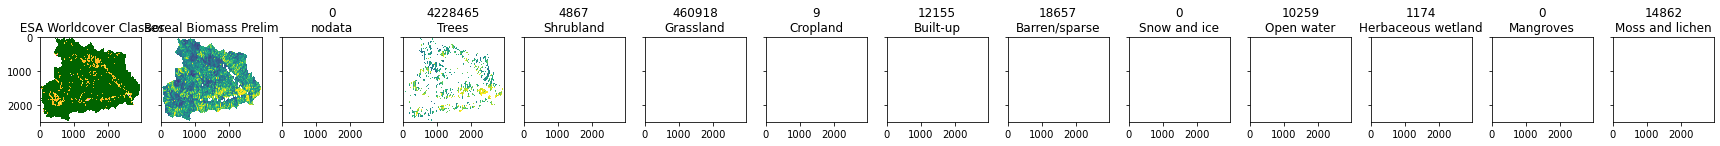

In [234]:
## %%time

area_pix_ha = 0.09

# The land cover values in which you want to summarize AGB
values_worldcover = [0,10,20,30,40,50,60,70,80,90,95,100] #'Trees', 'Shrubland', 'Grassland','Cropland', 'Barren / sparse vegetation', 'Herbaceous wetland','Moss and lichen'

fig, axes = plt.subplots(nrows=1, ncols=len(values_worldcover)+2, figsize=(30,10), sharex=True, sharey=True)

# Read back in the topo_stack_cog_fn and plot

with rasterio.open(BASIN_COG_DICT['landcover_cog_fn']) as dataset:

    print(dataset.count)
    
    lc_arr = dataset.read(1)
    print(f"lc_arr shape: {lc_arr.shape}")
    
    # Plotting
    names_worldcover = ['nodata','Trees', 'Shrubland', 'Grassland','Cropland','Built-up','Barren/sparse','Snow and ice','Open water','Herbaceous wetland','Mangroves','Moss and lichen']
    cols_worldcover = ["white","#006400","#ffbb22","#ffff4c","#f096ff","#fa0000","#b4b4b4","#f0f0f0","#0064c8","#0096a0","#00cf75","#fae6a0"]
    #cols_worldcover = ["white","green","orange","yellow","purple","red","brown","gray","blue","pink","cyan","black"]
    cols_mask = ["white", "red"]
    
    values_mask = [0,1]

    cmap_worldcover = ListedColormap(cols_worldcover)
    norm_worldcover = BoundaryNorm(values_worldcover, len(cols_worldcover))

    cmap_masked = ListedColormap(cols_mask)
    norm_masked= BoundaryNorm(values_mask, len(cols_mask))
    
    axes[0].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
    axes[0].set_title(f" ESA Worldcover Classes")
    
    # Find sum of AGB per LC class
    # multiply by AGB values and sum
    with rasterio.open(BASIN_COG_DICT['biomass_cog_fn']) as dataset_agb:
        
        agb_arr = dataset_agb.read(1)
        print(f"agb nodata value: {dataset_agb.nodata}")
        
        agb_arr = np.ma.masked_where( (lc_arr==0) | (agb_arr<0), agb_arr)
        
        print(f"agb_arr shape: {agb_arr.shape}")
        axes[1].imshow(agb_arr, clim=(0,100))
        axes[1].set_title(f"Boreal Biomass Prelim")
    
        for i, LC_VALUE in enumerate(values_worldcover):

            LC_NAME = names_worldcover[i]
            print(i, LC_NAME, LC_VALUE)

            # For LC value of interest
            lc_agb_arr = np.ma.masked_where( (lc_arr == 0) | (agb_arr < 0) | (lc_arr != LC_VALUE) , agb_arr)
            
            num_lc_pixels_in_mask = lc_agb_arr.count()
            print(f"\t# lc pixels in mask:\t\t\t\t{num_lc_pixels_in_mask}")
            
            #if LC_VALUE == 40:
            #    print(f"\t\t{sum(lc_agb_arr[lc_agb_arr.mask == False].tolist()) / (num_lc_pixels_in_mask * area_pix_ha)}")
            
            if num_lc_pixels_in_mask > 0:
                
                print(f"\tMin, Mean, Max values of array:\t\t\t{lc_agb_arr.min()}, {round(lc_agb_arr.mean(),2)} , {lc_agb_arr.max()}")

                # ***To get error bars on total (Mg), need to have mean AGB raster and sd AGB raster, and use them to sample a normal distribution of AGB values per pixel, n=100 times per pixel?
                # Then get all the totals from the n layers, and get the mean total and the sd of the total
                print(f"\tTotal AGB (Mg) in {LC_NAME}:\t\t\t{round( lc_agb_arr.sum() / (num_lc_pixels_in_mask * area_pix_ha), 2)}")
            
            # To plot with a legend:
            # https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
            axes[i+2].plot(lc_agb_arr, clim=(0,100))
            axes[i+2].set_title(f"{num_lc_pixels_in_mask}\n{LC_NAME}")
            #show(lc_mask, cmap=cmap_masked, norm=norm_masked)
            #show_hist(lc_mask, bins=len(values_masked)+1, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of ESA Worldcover Class Values")

In [188]:
lc_arr = np.array([0,10,20,30,40,10])
agb_arr = np.array([-9999.0,20.78,5.65,200.8,45.7,10.0])  

print(f"lc_arr shape: {lc_arr.shape}")
print(f"agb_arr shape: {agb_arr.shape}")

LC_VALUE = 10

# For LC value of interest, set to 1, else mask out
lc_agb_arr = np.ma.masked_where( (lc_arr == 0) | (agb_arr < 0) | (lc_arr!=LC_VALUE) , agb_arr)

num_lc_pixels_in_mask = lc_agb_arr.count()
print(f"# lc pixels in mask: {num_lc_pixels_in_mask}")

print(lc_agb_arr)
print(lc_agb_arr.sum())

lc_arr shape: (6,)
agb_arr shape: (6,)
# lc pixels in mask: 2
[-- 20.78 -- -- -- 10.0]
30.78


### Build the VRT of the Worldcover covar data on s3 for the region

In [28]:
for bandnum, bandname in bands_dict.items():
    
    print(bandnum, bandname)
    
    # Write a vrt list
    covar_vrt_list = os.path.join(outdir, f"cog_tindex.{bandname}.{tile_group_region_string}.txt")

    with open(covar_vrt_list, 'w') as f:

        for text in covar_footprint_tiles_subset['s3_path'].tolist():
            f.write(text.replace("s3:/","/vsis3") + '\n')
    
    # Make vrt name from text file name
    covar_vrt_fn = covar_vrt_list.replace('.txt','.vrt')

    #get the bbox as part of the gdalbuildvrt and define it, to save time calculating
    extent = [int(b) for b in covar_footprint_tiles_subset.total_bounds]
    
    extent_str = ' '.join(str(e) for e in extent)
    
    ###!time gdalbuildvrt -b 1 -te 458521 1503304 5408522 7623304 -input_file_list $vrt_list $vrt_fn
    !time gdalbuildvrt -b $bandnum -te $extent_str -input_file_list $covar_vrt_list $covar_vrt_fn
    print(covar_vrt_fn)
    

1 esa_worldcover_v100_2020
0...10...20...30...40...50...60...70...80...90...100 - done.

real	1m0.068s
user	0m0.868s
sys	0m0.063s


In [33]:
!pip install -U rioxarray

  Using cached rioxarray-0.9.1-py3-none-any.whl
  Using cached xarray-0.20.2-py3-none-any.whl (845 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:

import rioxarray
import fiona

covar_vrt_fn = '/projects/my-public-bucket/analyze_agb/cog_tindex.esa_worldcover_v100_2020.wwf_boreal_america.vrt'
# result from build_stack.py - a LC clip to a hydrobasin at 30m in boreal equal area prj
covar_vrt_fn = '/projects/tmp/esa_worldcover_v100_2020_4070084980_cog.tif'
vrt_fn = '/projects/my-public-bucket/analyze_agb/cog_tindex.agb_mean.america.vrt'
# open the rasters
rds1 = rioxarray.open_rasterio(covar_vrt_fn)
rds2 = rioxarray.open_rasterio(vrt_fn)

In [3]:
rds2

<xarray.DataArray (band: 1, y: 204000, x: 165000)>
[33660000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.585e+05 4.586e+05 ... 5.408e+06 5.409e+06
  * y            (y) float64 7.623e+06 7.623e+06 ... 1.503e+06 1.503e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -3.399999952144364e+38
    scale_factor:  1.0
    add_offset:    0.0

In [30]:
# Get a geom that matches some HYBAS_ID
with fiona.open('/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev04_v1c.gpkg') as src:
    geom_crs = src.crs_wkt
    for feature in src:
        if feature['properties']["HYBAS_ID"] == 8040007030:
            geom = feature["geometry"]

In [33]:
z = gpd.read_file('/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev04_v1c.gpkg')
z.loc[0]

HYBAS_ID                                            8040000010
NEXT_DOWN                                                    0
NEXT_SINK                                           8040000010
MAIN_BAS                                            8040000010
DIST_SINK                                                  0.0
DIST_MAIN                                                  0.0
SUB_AREA                                               55238.6
UP_AREA                                                55238.6
PFAF_ID                                                   8111
SIDE                                                         M
LAKE                                                         0
ENDO                                                         0
COAST                                                        1
ORDER                                                        0
SORT                                                         1
geometry     (POLYGON ((-144.3680555555555 59.983333333

#### Why doesnt this clip work?

In [ ]:
clipped = rioxarray.open_rasterio(
    covar_vrt_fn,
    masked=True,
).rio.clip(z.loc[0].geometry, from_disk=True)
#rds1_clipped = rds1.rio.clip(geom, geom_crs)

In [ ]:
if False:
    rds1_clipped = rds1.rio.clip(geoms, geom_crs)
    rds2_clipped = rds2.rio.clip(geoms, geom_crs)

    # ensure the rasters have the same projection/transform/shape
    rds2_match = rds2_clipped.rio.reproject_match(rds2_clipped)

## Loop over Worldcover classes, providing them as masks to AGB raster
https://gis.stackexchange.com/questions/345917/overlay-two-raster-geotiffs-using-rasterio-mask
* build this into ExtractUtils.get_raster_zonalstats()

In [ ]:
# Just use output hydrobasin extent raster from build_stack
rds2_match = rds2.rio.reproject_match(rds1)

/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (-3.399999952144364e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


In [ ]:


try:

    #out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=feature_gdf.geometry, crop=True)
    # the shapes are the geometry of the regional hydrobasin
    out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=ZONAL_STATS_DICT[]'REGION_FN'], crop=True)

    # Copy the metadata
    out_meta = r.meta.copy()
    out_meta.update({"driver": "GTiff",
             "height": out_image.shape[1],
             "width": out_image.shape[2],
             "transform": out_transform,
             "crs":r.crs.to_proj4()}
                     )
    with rasterio.open(out_r_fn, "w", **out_meta) as out_r:
        out_r.write(out_image)

        print("Zone", zonenum, "clip of",  os.path.split(r_fn)[1])
        print("Writing clipped subset to", out_r_fn)

        #show(out_r, cmap='viridis') # <-- this show() is not working here..need to read the raster in again?

    # HERE IS WHERE WE CAN DO rasterstat's zonal_stats.
    if SHOW_CLIP:
        show((rasterio.open(out_r_fn)), cmap='viridis')# <-- this show() works

except ValueError:
    print(zone_name, " has no intersection with", os.path.split(r_fn)[1])
    no_raster_intersection_list.append(zone_name)

In [ ]:
import rioxarray
import fiona

# open the rasters
rds1 = rioxarray.open_rasterio("21_32/LC080210322016072801T1/LC08_L1TP_021032_20160728_20170221_01_T1_sr_band3.tif")
rds2 = rioxarray.open_rasterio("CDL_2018_18.tif")

# clip the rasters
with fiona.open(parc_2018, layer='County_Land_Parcels_IGIO_IN_Apr2018') as src:
    geom_crs = src.crs_wkt
    geoms = [feature["geometry"] for feature in src]

rds1_clipped = rds1.rio.clip(geoms, geom_crs)
rds2_clipped = rds2.rio.clip(geoms, geom_crs)

# ensure the rasters have the same projection/transform/shape
rds2_match = rds2_clipped.rio.reproject_match(rds2_clipped)

# write to file
rds1_clipped.rio.to_raster("LC08_L1TP_021032_20160728_20170221_01_T1_sr_band3__clipped.tif")
rds2_match.rio.to_raster("CDL_2018_18__clipped_reprojected.tif")

## For a tile, run build_stack.py

In [ ]:
args = f"--in_tile_fn {INDEX_FN} \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 0 \
--in_tile_layer {INDEX_LYR} \
-o /projects/test_data/ \
--topo_off \
--covar_src_name esa_worldcover_v100_2020 \
--covar_tile_fn {COVAR_FOOTPRINTS_FN} \
--in_covar_s3_col s3_path \
--input_nodata_value 0"
print(args)
!python build_stack.py $args